In [176]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [177]:
pwd

'/home/jupyter-cshobe/pyABC/full_inversion/orange_section_R6/prepro'

In [178]:
#array of bedrock elevation at every time
#make x, t array of bedrock elevation
n_nodes = 67
dx = 10000
x = np.arange(0, n_nodes * dx, dx)
br_elev_array = np.zeros((130000, n_nodes))
#define IC:
#br_elev_array[0, :] = np.exp(- (x - 760000) / 100000) + -2000 #build the initial topography

In [179]:
#define FC:
from xml.dom import minidom

def extract_surface(filename):

    doc = minidom.parse(filename)  # parseString also exists
    path_strings = [path.getAttribute('d') for path in doc.getElementsByTagName('path')]
    doc.unlink()
    top_of_syn_rift = path_strings[-1] #ignore all the other paths, which are the grid lines
    top_of_syn_rift_no_m = top_of_syn_rift[1:]
    n_coords = top_of_syn_rift.count(',')
    x_coords = np.zeros(n_coords)
    y_coords = np.zeros(n_coords)
    coords_list = top_of_syn_rift_no_m.split('L')
    iter = 0
    for i in coords_list:
        a = i.split(',')
        x_coords[iter] = float(a[0])
        y_coords[iter] = float(a[1])
        iter += 1
    
    x_coords = x_coords
    #y_coords = -y_coords[::-1]
    return x_coords, y_coords

In [180]:
def untransform_surface(x_imported, y_imported, transform):
    a = transform[0]
    b = transform[1]
    c = transform[2]
    d = transform[3]
    e = transform[4]
    f = transform[5]
    
    x_untransformed = (x_imported - c * y_imported - e) / a
    y_untransformed = (y_imported - b * x_imported - f) / d
    
    #x_untransformed = a * x_imported + c * y_imported + e
    #y_untransformed = b * x_imported + d * y_imported + f
    return x_untransformed, y_untransformed

In [181]:
#this isn't yet scaled to the actual height. To do this:
    #for x values: (x / x_max) * length pf section (km)
    #for y values: (y/y_max) * max real elevation (km)

def scale_surface(x_imported, y_imported):
    #y_imported = -y_imported #[::-1]
    
    section_max_x = 673077
    ##the reason max_drawn_x is needed in this seciton si that not all drawn lines are drawn to the end
    #of the section.
    print(max(x_imported))
    max_drawn_x = 804.852  #this needs to be the largest x (pre-scaling) of any section line
    y_imported = -y_imported #[::-1]
    x_new = -(x_imported / max_drawn_x) * section_max_x + section_max_x
    y_new = y_imported + abs(min(y_imported))
    print(abs(max(y_new)))
    y_new = (y_new / 47.315) * 6643 #59.231 is the maximum y-value found from any read-in svg; 9400 is max amplitude of any line in the section measured in Afdesign.
    y_new -= max(y_new)

#y_pos = y_coords
#y_new = (y_pos - min(y_pos))
#y_new = (y_coords / max(abs(y_coords))) * 7.3
#y_new += (8 - max(y_new))
#y_new = y_new - 8
    return x_new, y_new


In [182]:

#better test:
from scipy.signal import savgol_filter


def smooth_surface(y_new, window_size):

    y_smoothed = savgol_filter(y_new, window_size, 3)
    return y_smoothed
    
def filter_surface(x_new, y_smoothed, n_x_nodes):
    test_x_new_smoothed = x_new[:len(y_smoothed)]
    final_cond = np.zeros(n_x_nodes)
    for j in range(len(x)):
        index_of_nearest_x = (np.abs(test_x_new_smoothed-x[j])).argmin()
        #print(model_x[j])
        #print(index_of_nearest_x)
        final_cond[j] = y_smoothed[index_of_nearest_x]
    return final_cond

#final_cond = test_final_cond.copy()

In [183]:
#list names of svgs from which to import
folder = 'strat_data_lines_EDIT/'
filenames = [folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_synrift_only.svg', 
             folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_U1_only.svg', 
             folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_U2_only.svg', 
             folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_U3_only.svg', 
             folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_U4_only.svg', 
             folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_U5_only.svg', 
             folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_U6_only.svg', 
             folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_U7_only.svg', 
             folder + '3_A15_coupe synth+RC1703_edit_TD_CS_top_of_U8_only.svg', ]
#transforms = [(1, 0, 0, 1, 60.6397, 181.125),
#             (4.16667,0,0,4.16667,252.665,742.2),
#             (4.16667,0,0,4.16667,252.665,736.209),
#             (4.16667,0,0,4.16667,252.665,726.721),
#             (4.16667,0,0,4.16667,252.665,695.75),
#             (4.16667,0,0,4.16667,252.665,695.75),
#             (4.16667,0,0,4.16667,252.665,695.75),
#             (4.16667,0,0,4.16667,252.665,695.75),
#             (4.16667,0,0,4.16667,252.665,695.75),]


def import_and_transform_all_surfaces(filenames):
    array_of_surfaces = np.zeros((len(filenames), n_nodes))
    i = 0
    for name in filenames:
        plt.figure(figsize=(18, 2))
        #transform = transforms[i]
        #import surface
        #filename = '5_A22+RC1214_edit_TD_CS_lineonly.svg'
        x_imported, y_imported = extract_surface(name)
        #print(min(x_imported))
        #print(max(x_imported))

        #untransform surface
        #x_untransformed, y_untransformed = untransform_surface(x_imported, y_imported, transform)
    
        #scale surface
        x_new, y_new = scale_surface(x_imported, y_imported)
        plt.plot(x_new, y_new)
        if i ==0:
            print(np.min(y_new))
        #smooth surface
        window_size = 75
        y_smooth = smooth_surface(y_new, window_size) #y_smooth = y_new.copy()#
        plt.plot(x_new, y_smooth)
        plt.xlabel(name)
        #NOW, because U1 and U2 are very short, we need to 
        #shift them to start at x = 0. So:
        if name == filenames[3]: #if U1
            x_new -= min(x_new)
            plt.plot(x_new, y_smooth, color = 'green')
        
        #filter surface
        final_cond = filter_surface(x_new, y_smooth, n_nodes)
        if name == filenames[3]:
            plt.figure()
            plt.plot(x[0:len(final_cond)], final_cond, color = 'green')
    
        ###
        #smooth
        #window_size = 75
        #y_smooth = smooth_surface(y_imported, window_size)
        
        #scale
        #x_new, y_new = scale_surface(x_imported, y_smooth)
        
        #filter
        #n_x_nodes = 140
        #final_cond = filter_surface(x_new, y_new, n_x_nodes)
        ###
    
        #plt.figure()
        #plt.plot(x_untransformed,y_untransformed)
        array_of_surfaces[i] = final_cond
        i += 1
    return array_of_surfaces



804.852
47.315
-6643.0
804.852
47.315
804.852
45.983000000000004
711.206
40.556
804.852
35.999
804.852
35.589
804.852
35.231
804.852
35.231
804.852
34.821


<Figure size 1296x144 with 0 Axes>

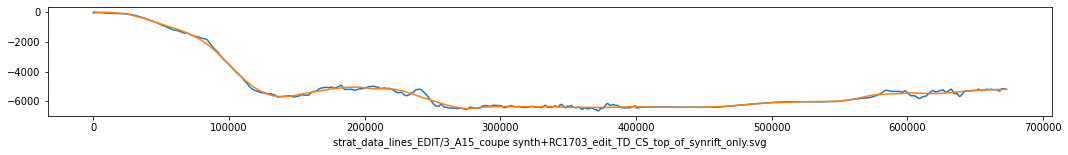

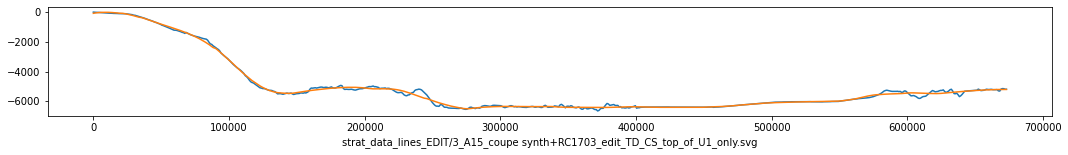

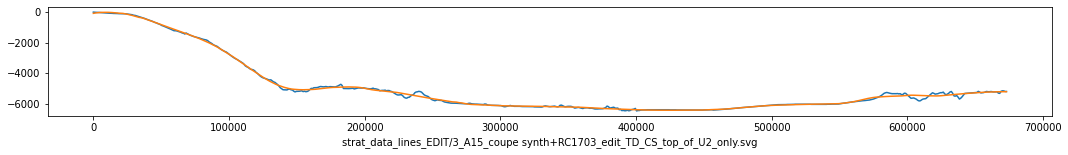

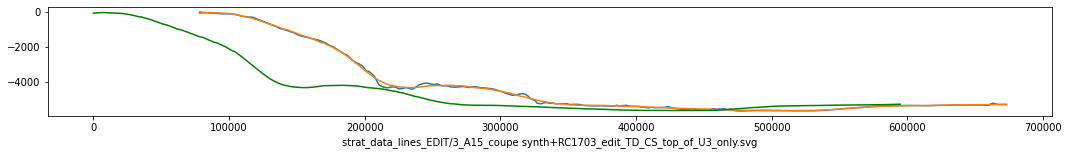

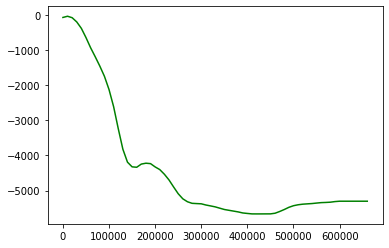

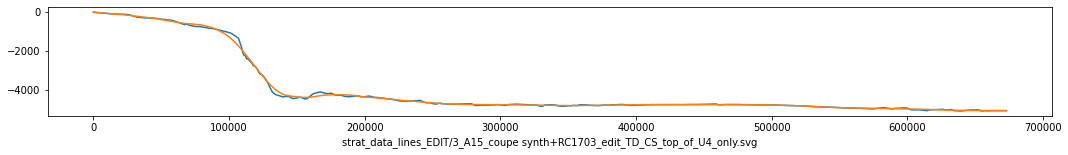

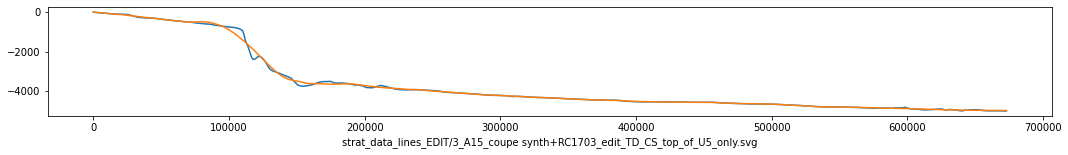

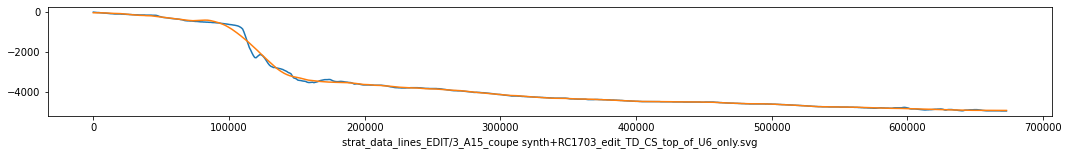

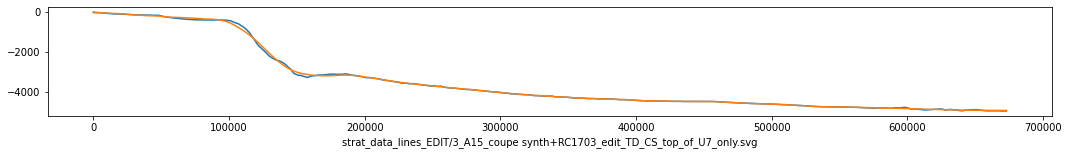

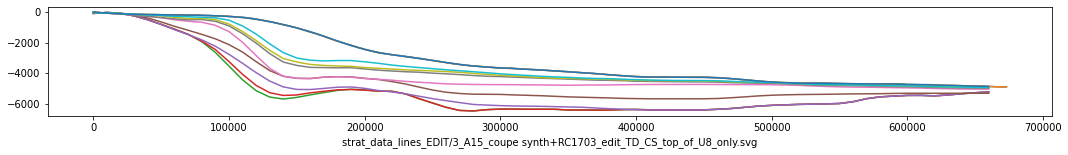

In [184]:
plt.figure(figsize=(18, 2))
all_surfaces = import_and_transform_all_surfaces(filenames)
for i in range(len(filenames)):
    plt.plot(x, all_surfaces[i])

In [185]:
#DON'T USE THESE LINES: THEY MAKE THE MODEL SUCK
#low = np.min(all_surfaces[0, 57:])
#all_surfaces[0, 57:] = low
np.min(np.diff(all_surfaces[-2, :])/10000)
np.min(np.diff(all_surfaces[-2, 10:30])/10000)
#np.min(all_surfaces[0, :])

-0.06433724245817996

In [186]:
np.min(all_surfaces[0, :])

-6462.376920714487

(0.0, 100000.0)

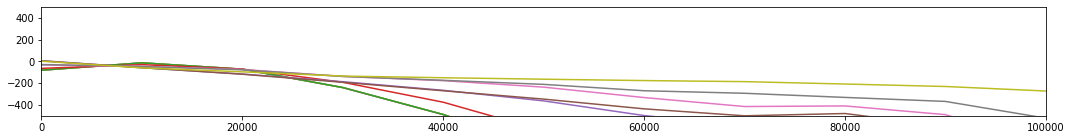

In [187]:
plt.figure(figsize=(18, 2))
for i in range(len(filenames)):
    #plt.figure(figsize=(18, 2))

    plt.plot(x, all_surfaces[i])
plt.ylim(-500, 500)
plt.xlim(0, 100000)

(0.0, 100000.0)

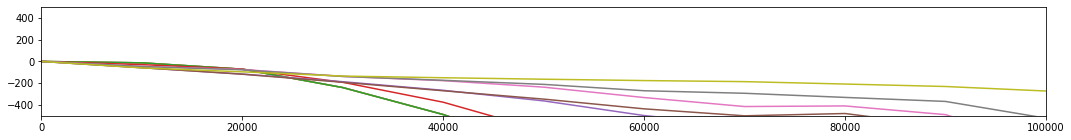

In [188]:
all_surfaces[:, 0] = 0
all_surfaces = np.clip(all_surfaces,-999999,0)
plt.figure(figsize=(18, 2))
for i in range(len(filenames)):
    #plt.figure(figsize=(18, 2))

    plt.plot(x, all_surfaces[i])
plt.ylim(-500, 500)
plt.xlim(0, 100000)

In [189]:
#now set the initial condition (THIS IS VERY HEURISTIC)
init_cond = all_surfaces[0, :] / 3
final_cond = all_surfaces[0, :]

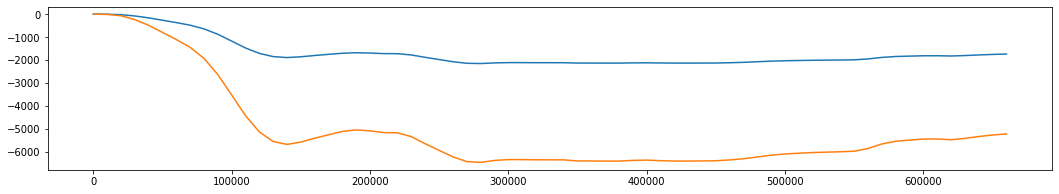

In [190]:
plt.figure(figsize=(18,3))
plt.plot(x,init_cond)
#plt.plot(x_new, y_new)
plt.plot(x,final_cond)

(-2600.0, 0.0)

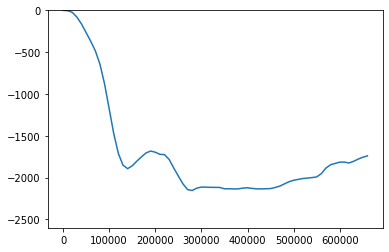

In [191]:
br_elev_array[0, :] = init_cond[:]
plt.plot(x,br_elev_array[0, :])
dz = init_cond - final_cond
plt.ylim(-2600, 0)

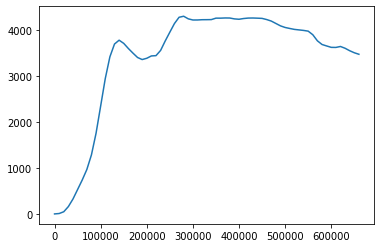

In [192]:
plt.plot(x, dz)

In [193]:
#now do a loop to populate every column with time series of bedrock elevation

bendy_factor = 5 #this sets the shape of the exponential decay...
#coeff = init_cond.copy() #calculate coefficient at every point
k = bendy_factor * np.log(final_cond / init_cond) / 130000000 #calculate k at every point
t = np.arange(0, 130000000, 1000)
for i in range(len(x)): #for each element of x...
    br_elev_array[:, i] = dz[i]*np.exp(-k[i] * t) + final_cond[i]


/home/jupyter-cshobe/.conda/envs/charlie-env-2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [194]:
np.exp(-k*130001000) * dz

array([        nan,  0.03528907,  0.19472482,  0.65901596,  1.33968702,
        2.18842084,  3.03918209,  3.9798461 ,  5.29497338,  7.23243226,
        9.67821907, 12.13994798, 14.08791866, 15.235234  , 15.58037171,
       15.29608209, 14.83897137, 14.42336394, 14.02949263, 13.84467951,
       13.95920763, 14.16843971, 14.19529618, 14.66390773, 15.5118758 ,
       16.29925946, 17.07405053, 17.6357235 , 17.72868001, 17.49555219,
       17.39245512, 17.39393048, 17.41761951, 17.42126601, 17.4279855 ,
       17.55796732, 17.55692203, 17.57422397, 17.56916893, 17.49141421,
       17.45860924, 17.52427389, 17.56451802, 17.57057753, 17.55523063,
       17.53647054, 17.43179157, 17.29520751, 17.07982612, 16.86463822,
       16.72156147, 16.63288355, 16.55008423, 16.50381201, 16.45684735,
       16.39172015, 16.0706224 , 15.52463232, 15.19577209, 15.06388095,
       14.93885008, 14.93124883, 15.01674869, 14.85728933, 14.63659629,
       14.45401293, 14.31768454])

[        nan  0.03529205  0.19474128  0.65907165  1.33980024  2.18860579
  3.03943894  3.98018244  5.29542087  7.23304349  9.67903699 12.14097395
 14.08910926 15.23652156 15.58168844 15.2973748  14.84022544 14.42458289
 14.0306783  13.84584956 13.96038735 14.16963712 14.19649586 14.66514701
 15.51318674 16.30063695 17.0754935  17.63721393 17.7301783  17.49703078
 17.393925   17.39540048 17.41909151 17.42273831 17.42945838 17.55945118
 17.5584058  17.57570921 17.57065374 17.49289244 17.46008471 17.5257549
 17.56600244 17.57206246 17.55671427 17.53795258 17.43326477 17.29666916
 17.08126958 16.86606349 16.72297464 16.63428923 16.55148292 16.50520678
 16.45823815 16.39310545 16.07198056 15.52594434 15.19705632 15.06515403
 14.9401126  14.93251071 15.01801779 14.85854495 14.63783327 14.45523447
 14.31889456]


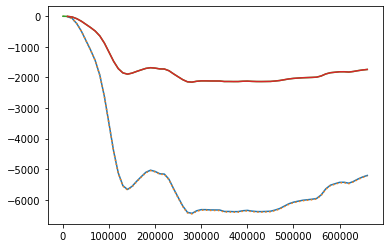

In [195]:
plt.plot(x, br_elev_array[-1, :])
plt.plot(x, final_cond, linestyle = ':')
plt.plot(x, init_cond)
plt.plot(x, br_elev_array[0, :])
t[-1]
print(br_elev_array[-1, :] - final_cond)

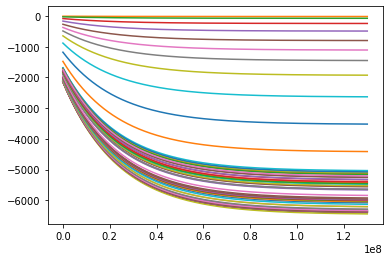

In [196]:
#test by plotting every point's subsidence time series
for i in range(len(x)):
    z_evol = br_elev_array[:, i]
    plt.plot(t, z_evol)

(0.0, 500000.0)

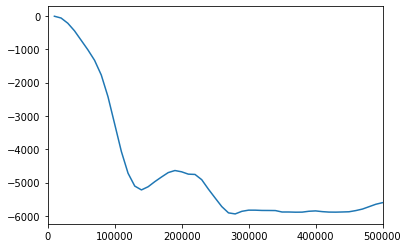

In [197]:
plt.plot(x, br_elev_array[50000, :])
plt.xlim(0, 500000)

In [198]:
#package the bedrock altitude array for xsimlab:
#bedrock_elev_array = xr.DataArray(br_elev_array, dims=['time', 'x'])
br_elev_array[:, 0] = 0. #keep left-most node always at z=0
br_elev_array

array([[ 0.00000000e+00, -4.28780305e+00, -2.36600655e+01, ...,
        -1.77842159e+03, -1.75623678e+03, -1.73967218e+03],
       [ 0.00000000e+00, -4.28816540e+00, -2.36620650e+01, ...,
        -1.77857188e+03, -1.75638519e+03, -1.73981919e+03],
       [ 0.00000000e+00, -4.28852773e+00, -2.36640643e+01, ...,
        -1.77872217e+03, -1.75653360e+03, -1.73996620e+03],
       ...,
       [ 0.00000000e+00, -1.28281141e+01, -7.07854389e+01, ...,
        -5.32062571e+03, -5.25425388e+03, -5.20469643e+03],
       [ 0.00000000e+00, -1.28281156e+01, -7.07854471e+01, ...,
        -5.32062633e+03, -5.25425449e+03, -5.20469704e+03],
       [ 0.00000000e+00, -1.28281171e+01, -7.07854553e+01, ...,
        -5.32062695e+03, -5.25425510e+03, -5.20469764e+03]])

In [199]:
#save out array as npy binary
np.save('bedrock_elev_array.npy', br_elev_array)

In [200]:
#test to make sure it can be loaded back in:
test = np.load('bedrock_elev_array.npy')

In [201]:
bedrock_elevation = xr.DataArray(test, dims=['time', 'x'])

In [202]:
pwd

'/home/jupyter-cshobe/pyABC/full_inversion/orange_section_R6/prepro'

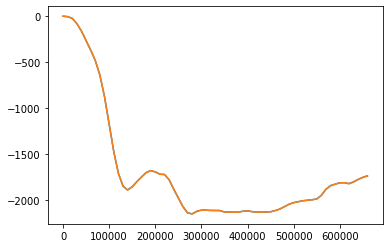

In [203]:
plt.plot(x,br_elev_array[0, :])
plt.plot(x,br_elev_array[1, :])



In [204]:
#now construct qs_in time series based on Baby 2019 data
#make array of qs based on Baby et al 2019 solid volumes


#qs_array = np.zeros(int(130000000 / 1000)) #there's a value for every timestep
#qs_array[0:17000] = 2700000.
#qs_array[17000:30000] = 4600000.
#qs_array[30000:36000] = 19900000.
#qs_array[36000:49000] = 51400000.
#qs_array[49000:64000] = 6100000.
#qs_array[64000:105000] = 600000.
#qs_array[105000:119000] = 2400000.
#qs_array[119000:] = 6200000.


## Update: qs array is built by integrating the dataset

In [205]:
phi = 0.56
z_star = 2830.
dx = 10000.
dt = 1000.
time_to_run = 130000000
qs_array = np.zeros(int(time_to_run / dt))

#duration of each layer from bottom to top
layer_starts = [0, 17000000, 30000000, 36000000, 49000000, 64000000, 100000000, 119000000]
layer_durations = [17000000, 13000000, 6000000, 13000000, 15000000, 36000000, 19000000, 11000000]

for i in range(8): #for each layer
    layer_start = int(layer_starts[i] / dt)
    layer_duration = int(layer_durations[i] / dt)
    
    tot_depth_top = all_surfaces[8, :]-all_surfaces[i + 1, :]
    tot_depth_bottom = all_surfaces[8, :]-all_surfaces[i, :]
    
    integral_at_upper_depth = phi * z_star * np.exp(-tot_depth_top/z_star) + tot_depth_top
    integral_at_lower_depth = phi * z_star * np.exp(-tot_depth_bottom/z_star) + tot_depth_bottom

    def_int = - (integral_at_upper_depth - integral_at_lower_depth)

    total_sed = np.sum(def_int) * dx #now have m2
    qs_over_time_period = total_sed / layer_durations[i] #17 million years #now have m2/yr
    qs_array[layer_start:layer_start + layer_duration] = qs_over_time_period

(0.0, 50.0)

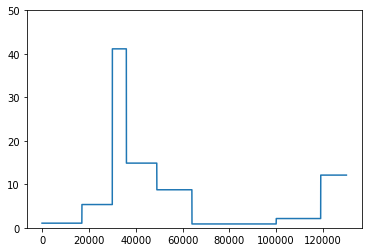

In [206]:
plt.plot(np.arange(len(qs_array)), qs_array)
plt.ylim(0, 50)

In [207]:
#save out array as npy binary
np.save('qs_array.npy', qs_array)

#save data!
#this is nrows=9 (bedrock + 8 other strat units), ncols = n_nodes. 
#It holds elevation of each layer at each node. NOT sed thickness, but absolute altitude.
np.save('all_surfaces.npy', all_surfaces)

In [28]:
#SAVE OUT THE SHORT ONES
#np.save('qs_array_short.npy', qs_array[:20000])
#np.save('bedrock_elev_array_short.npy', br_elev_array[:20000, :])

In [29]:
import numpy as np

In [33]:
test = np.load('bedrock_elev_array.npy')

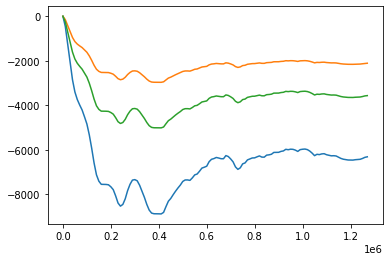

In [35]:
x = np.arange(0, 1280000, 10000)
import matplotlib.pyplot as plt
plt.plot(x, test[-1, :])
plt.plot(x, test[0, :])

plt.plot(x, test[10000, :])

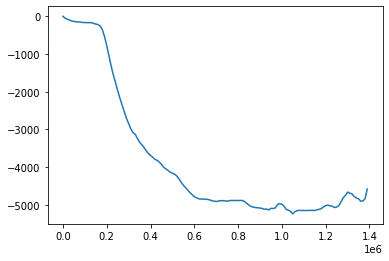

In [10]:
plt.plot(x, all_surfaces[-1, :])

In [29]:
integral_of_sed = np.sum(all_surfaces[-1, :] - all_surfaces[0, :])*10000

In [30]:
integral_of_sed

2183077506.1412015

(0.0, 1.0)

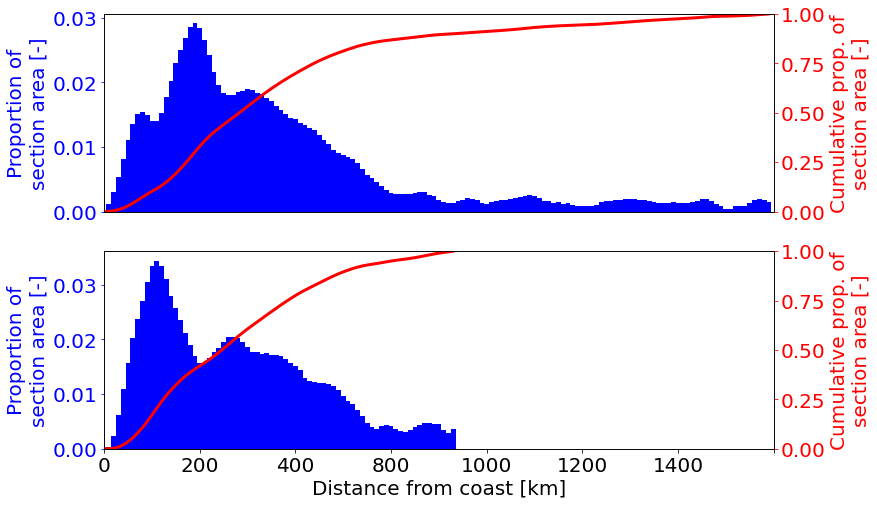

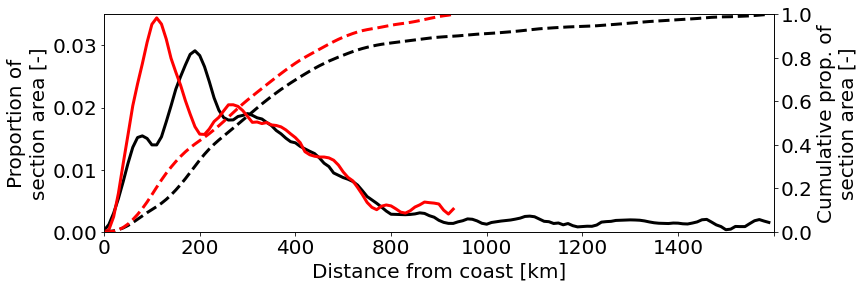

In [181]:
###now build volume vs distance
#and volume vs depth histograms
plt.rcParams.update({'font.size': 20})
#first, volume vs distance
volumes_binned = (all_surfaces[-1, :] - all_surfaces[0, :]) * 10000

fig1 = plt.figure(figsize = (12, 8))
ax1 = plt.subplot(211)

ax1.bar(np.arange(140), volumes_binned/np.sum(volumes_binned), color = 'blue', width=1)
#ax1.plot(x/1000, volumes_binned/np.sum(volumes_binned), linewidth = 3, color = 'blue')
ax1.set_xlim(0, 140)

ax1.set_ylabel(r'Proportion of' '\n' 'section area [-]', color='blue')#(r'Section area [m$^3$/m]')
#ax1.set_ylim(0, 0.03)
ax1.tick_params(axis='y', colors='blue')
ax1.get_xaxis().set_ticks([])

ax2 = ax1.twinx()
ax2.plot(np.arange(140), np.cumsum(volumes_binned/np.sum(volumes_binned)), linewidth = 3, color = 'r')
#ax2.plot(x/1000, np.cumsum(volumes_binned/np.sum(volumes_binned)), linewidth = 3, color = 'r')
ax2.set_ylim(0,1)
ax2.set_ylabel(r'Cumulative prop. of' '\n' 'section area [-]', color = 'red')#(r'Section area [m$^3$/m]')
ax2.tick_params(axis='y', colors='red')

#section R5:
sec5 = np.load('../../orange_section_R5/prepro/all_surfaces.npy')
volumes_binned5 = (sec5[-1, :] - sec5[0, :]) * 10000

#axes 3 and 4 are for section R5
ax3 = plt.subplot(212)
ax3.bar(np.arange(74), volumes_binned5/np.sum(volumes_binned5), color = 'blue', width=1)
ax3.set_xlabel('Distance from coast [km]')
ax3.tick_params(axis='y', colors='blue')
ax3.set_ylabel(r'Proportion of' '\n' 'section area [-]', color='blue')#(r'Section area [m$^3$/m]')
ax3.set_xlim(0, 140)
labels = ['0', '200', '400', '800', '1000', '1200', '1400']
ax3.set_xticklabels(labels)

ax4 = ax3.twinx()
ax4.plot(np.arange(74), np.cumsum(volumes_binned5/np.sum(volumes_binned5)), linewidth = 3, color = 'r')
ax4.set_ylabel(r'Cumulative prop. of' '\n' 'section area [-]', color = 'red')#(r'Section area [m$^3$/m]')
ax4.tick_params(axis='y', colors='red')
ax4.set_ylim(0,1)

fig2 = plt.figure(figsize=(12,4))
ax5 = plt.subplot()
ax5.plot(np.arange(140), volumes_binned/np.sum(volumes_binned), color = 'k', linewidth=3)
ax5.plot(np.arange(74), volumes_binned5/np.sum(volumes_binned5), color='red', linewidth=3)
ax5.set_ylim(0, 0.035)
ax5.set_xlim(0, 140)
ax5.set_ylabel(r'Proportion of' '\n' 'section area [-]', color='k')
ax5.set_xlabel('Distance from coast [km]')
ax5.set_xticklabels(labels)

ax6 = ax5.twinx()
ax6.plot(np.arange(140), np.cumsum(volumes_binned/np.sum(volumes_binned)), linewidth = 3, linestyle='--', color = 'k')

ax6.plot(np.arange(74), np.cumsum(volumes_binned5/np.sum(volumes_binned5)), linewidth = 3, linestyle='--', color = 'r')
ax6.set_ylabel(r'Cumulative prop. of' '\n' 'section area [-]', color = 'k')#(r'Section area [m$^3$/m]')
#ax6.tick_params(axis='y', colors='red')
ax6.set_ylim(0,1)

In [182]:
fig1.savefig('section_R4_volumes_with_distance.eps', dpi=1000, bbox_inches='tight')
fig2.savefig('all_sections_volumes_with_distance.eps', dpi=1000, bbox_inches='tight')

In [ ]:
#now do the same plot for R5, just because

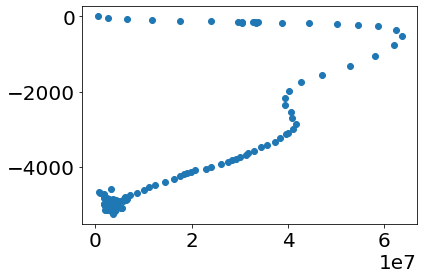

In [141]:
plt.scatter(volumes_binned, all_surfaces[-1, :])

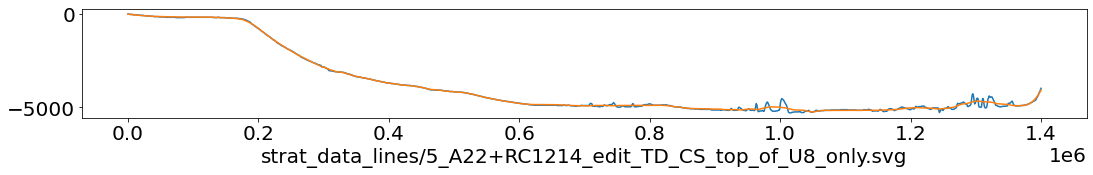

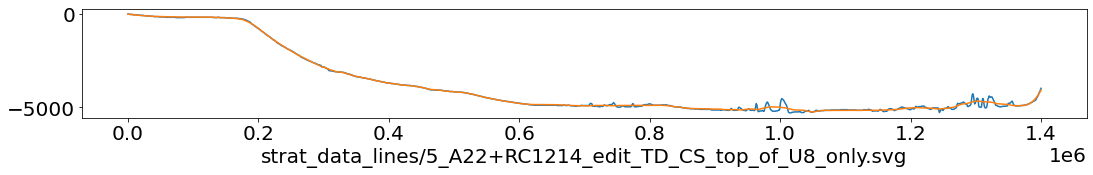

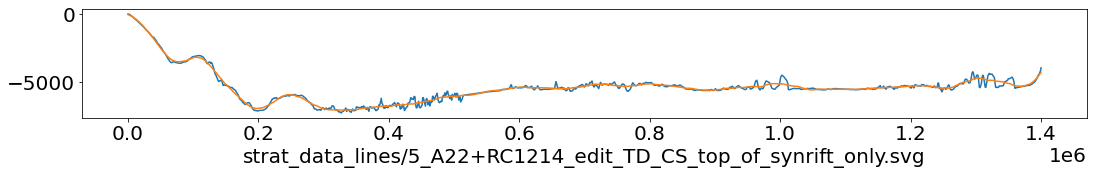

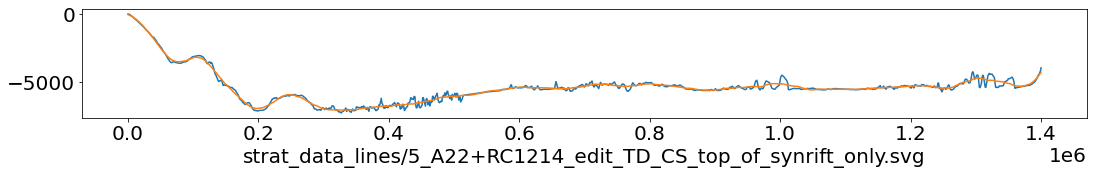

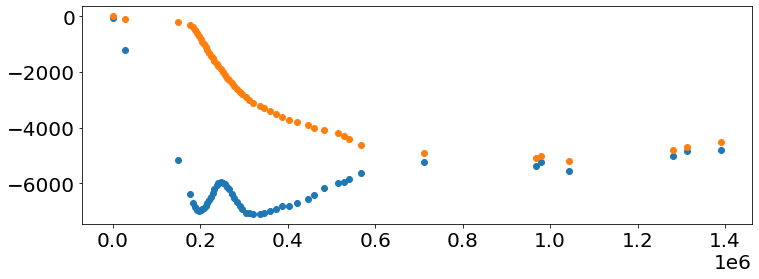

In [135]:
depths = all_surfaces[-1, :]
filename = folder + '5_A22+RC1214_edit_TD_CS_top_of_U8_only.svg'
br_filename = folder + '5_A22+RC1214_edit_TD_CS_top_of_synrift_only.svg'
#resample for depth
z = np.arange(0, -5300, -100)
n_z_nodes = 53
def filter_surface_depth(x_new, y_smoothed, n_z_nodes):
    #test_x_new_smoothed = x_new[:len(y_smoothed)]
    surface_at_every_depth = np.zeros(n_z_nodes)

    for j in range(len(z)):
        index_of_nearest_z = (np.abs(y_smoothed-z[j])).argmin()
        #print(model_x[j])
        #print(index_of_nearest_x)
        surface_at_every_depth[j] = y_smoothed[index_of_nearest_z]
    return surface_at_every_depth

def find_x_at_every_depth(x_new, y_smoothed, n_z_nodes):
    #test_x_new_smoothed = x_new[:len(y_smoothed)]
    x_at_every_depth = np.zeros(n_z_nodes)

    for j in range(len(z)):
        index_of_nearest_x = (np.abs(y_smoothed-z[j])).argmin()
        #print(model_x[j])
        #print(index_of_nearest_x)
        x_at_every_depth[j] = x_new[index_of_nearest_x]
    return x_at_every_depth

def import_and_transform_top_surface(filename):
    name = filename

    plt.figure(figsize=(18, 2))

    x_imported, y_imported = extract_surface(name)

    #scale surface
    x_new, y_new = scale_surface(x_imported, y_imported)
    plt.plot(x_new, y_new)
    #smooth surface
    window_size = 75
    y_smooth = smooth_surface(y_new, window_size) #y_smooth = y_new.copy()#
    plt.plot(x_new, y_smooth)
    plt.xlabel(name)
    #filter surface #at DEPTH intervals, NOT distance
    surface_at_every_depth = filter_surface_depth(x_new, y_smooth, n_z_nodes)
    x_at_every_depth = find_x_at_every_depth(x_new, y_smooth, n_z_nodes)    
    
    return (x_at_every_depth, surface_at_every_depth)

def import_and_smooth_bedrock_surface(filename):
    name = filename

    plt.figure(figsize=(18, 2))

    x_imported, y_imported = extract_surface(name)

    #scale surface
    x_new, y_new = scale_surface(x_imported, y_imported)
    plt.plot(x_new, y_new)
    #smooth surface
    window_size = 75
    y_smooth = smooth_surface(y_new, window_size) #y_smooth = y_new.copy()#
    plt.plot(x_new, y_smooth)
    plt.xlabel(name)
    #filter surface #at DEPTH intervals, NOT distance
    #surface_at_every_depth = filter_surface_depth(x_new, y_smooth, n_z_nodes)
    #x_at_every_depth = find_x_at_every_depth(x_new, y_smooth, n_z_nodes)    
    
    return (x_new, y_smooth)

#br_at_z_intervals = 
x_at_every_depth = import_and_transform_top_surface(filename)[0]
surface_at_every_depth = import_and_transform_top_surface(filename)[1]
smoothed_bedrock_x = import_and_smooth_bedrock_surface(br_filename)[0]
smoothed_bedrock_surface = import_and_smooth_bedrock_surface(br_filename)[1]

#finally, get only bedrock surface 
def find_br_at_every_x(x_new, y_smoothed, nx):
    #test_x_new_smoothed = x_new[:len(y_smoothed)]
    br_at_every_x = np.zeros(nx)

    for j in range(nx):
        index_of_nearest_x = (np.abs(x_new-x_at_every_depth[j])).argmin()
        #print(model_x[j])
        #print(index_of_nearest_x)
        br_at_every_x[j] = y_smoothed[index_of_nearest_x]
    return br_at_every_x

br_at_every_x = find_br_at_every_x(smoothed_bedrock_x, smoothed_bedrock_surface, len(x_at_every_depth))

fig2 = plt.figure(figsize = (12, 4))
ax1 = plt.subplot()
ax1.scatter(x_at_every_depth,br_at_every_x)
ax1.scatter(x_at_every_depth,surface_at_every_depth)

#ax1.scatter(volumes_binned/np.sum(volumes_binned), depths)

In [ ]:
depth1 = surface_at_every_depth - br_at_every_depth
vols = depth1*100
plt.barh()

In [122]:
z/y_at_z_intervals

array([0.        , 1.00416601, 0.98679628, 1.00481602, 1.00107138,
       1.01899557, 1.00256332, 1.00749305, 1.00384942, 0.99406539,
       1.01183618, 1.00121823, 0.99450935, 0.99258618, 0.99458447,
       0.99913741, 1.00378349, 0.99544512, 1.00205712, 0.99773708,
       0.99534454, 0.99549745, 0.99805451, 1.00242126, 0.99985132,
       1.00332278, 1.00002169, 0.99918966, 1.00069968, 0.99802635,
       1.00082922, 1.00017408, 0.99900637, 0.99998593, 0.99936621,
       1.00114448, 0.99897393, 0.99891632, 0.99946858, 1.00006351,
       0.99907319, 1.00083712, 0.99950328, 0.99976668, 1.00025788,
       0.99998792, 0.99966001, 1.00000584, 0.99992145, 0.99996324,
       1.00000889, 1.00001511, 0.9996223 ])

In [116]:
np.arange(0, -5300, -100)

array([    0,  -100,  -200,  -300,  -400,  -500,  -600,  -700,  -800,
        -900, -1000, -1100, -1200, -1300, -1400, -1500, -1600, -1700,
       -1800, -1900, -2000, -2100, -2200, -2300, -2400, -2500, -2600,
       -2700, -2800, -2900, -3000, -3100, -3200, -3300, -3400, -3500,
       -3600, -3700, -3800, -3900, -4000, -4100, -4200, -4300, -4400,
       -4500, -4600, -4700, -4800, -4900, -5000, -5100, -5200])